In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

import statsmodels.api as sm
from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model5
ndbs
Thu Feb  3 14:25:57 PST 2022


# Goal: Plot wasting and stunting over time in each scenario

This time trend will be used to compute annual average rate of reduction (AARR) for wasting and stunting.

# Create empty dictionary to store figures

In [23]:
figs = {}

# Load results

In [2]:
results = csr.VivariumResults.cleaned_from_model_spec('5.3.2')
results.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'births',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [4]:
results.births

,sex,year,measure,input_draw,scenario,value,insecticide_treated_nets,maternal_supplementation,maternal_malnutrition
0,female,2022,birth_weight_sum,29,baseline,0.0,covered,bep,cat2
1,female,2022,birth_weight_sum,29,baseline,0.0,uncovered,bep,cat2
2,female,2022,birth_weight_sum,29,baseline,0.0,covered,mmn,cat2
3,female,2022,birth_weight_sum,29,baseline,0.0,uncovered,mmn,cat2
...,...,...,...,...,...,...,...,...,...
23036,male,2026,total_births,946,wasting_treatment,369.0,covered,ifa,cat1
23037,male,2026,total_births,946,wasting_treatment,1082.0,uncovered,ifa,cat1
23038,male,2026,total_births,946,wasting_treatment,260.0,covered,uncovered,cat1
23039,male,2026,total_births,946,wasting_treatment,803.0,uncovered,uncovered,cat1


In [3]:
results.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,x_factor,sq_lns,mam_treatment,sam_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,covered,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,covered,covered,covered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,covered,uncovered,covered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,covered,uncovered,covered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...,...,...
184316,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,2509.615332,cat2,uncovered,covered,uncovered,2_to_4
184317,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,2311.608487,cat1,uncovered,covered,uncovered,2_to_4
184318,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,1076.795346,cat2,uncovered,uncovered,uncovered,2_to_4
184319,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,992.061602,cat1,uncovered,uncovered,uncovered,2_to_4


In [18]:
results.wasting_state_person_time.scenario.unique()

array(['baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment'],
      dtype=object)

# Compute wasting prevalence

In [40]:
wasting_prevalence = csr.get_prevalence(results, 'wasting_state', ['year'], multiplier=100)
wasting_prevalence

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,mild_child_wasting,20.639356,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,moderate_acute_malnutrition,7.477660,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,severe_acute_malnutrition,1.873702,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,susceptible_to_child_wasting,70.009281,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
956,2026,946,wasting_treatment,mild_child_wasting,20.911748,state_person_time,state_person_time,100,prevalence
957,2026,946,wasting_treatment,moderate_acute_malnutrition,6.141832,state_person_time,state_person_time,100,prevalence
958,2026,946,wasting_treatment,severe_acute_malnutrition,1.484293,state_person_time,state_person_time,100,prevalence
959,2026,946,wasting_treatment,susceptible_to_child_wasting,71.462127,state_person_time,state_person_time,100,prevalence


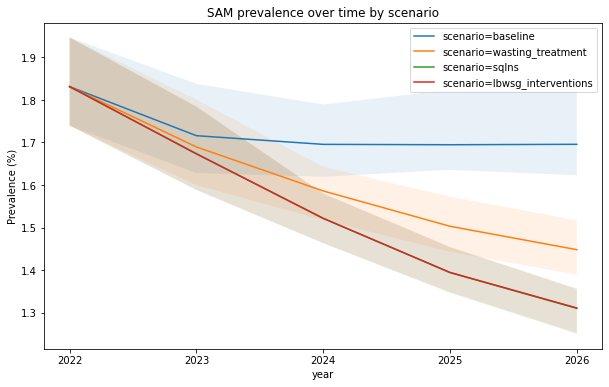

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    wasting_prevalence.query("wasting_state == 'severe_acute_malnutrition'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "SAM prevalence over time by scenario"),
);
figs[title] = fig

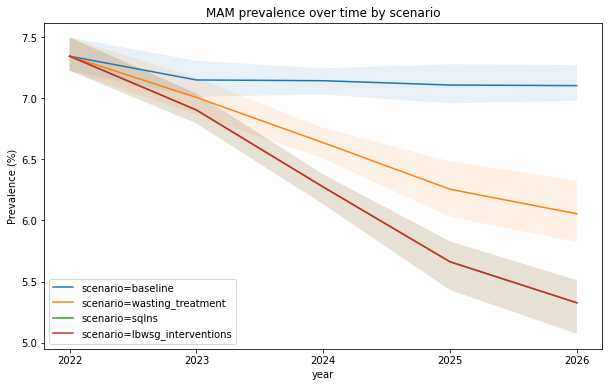

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    wasting_prevalence.query("wasting_state == 'moderate_acute_malnutrition'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "MAM prevalence over time by scenario"),
);
figs[title] = fig

In [26]:
figs.keys()

dict_keys(['SAM prevalence over time by scenario', 'MAM prevalence over time by scenario'])

# Compute stunting prevalence

In [27]:
stunting_prevalence = csr.get_prevalence(results, 'stunting_state', ['year'], multiplier=100)
stunting_prevalence

,year,input_draw,scenario,stunting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,cat1,16.890041,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,cat2,17.604816,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,cat3,19.781513,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,cat4,45.723630,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
956,2026,946,wasting_treatment,cat1,16.386116,state_person_time,state_person_time,100,prevalence
957,2026,946,wasting_treatment,cat2,18.443104,state_person_time,state_person_time,100,prevalence
958,2026,946,wasting_treatment,cat3,20.453433,state_person_time,state_person_time,100,prevalence
959,2026,946,wasting_treatment,cat4,44.717346,state_person_time,state_person_time,100,prevalence


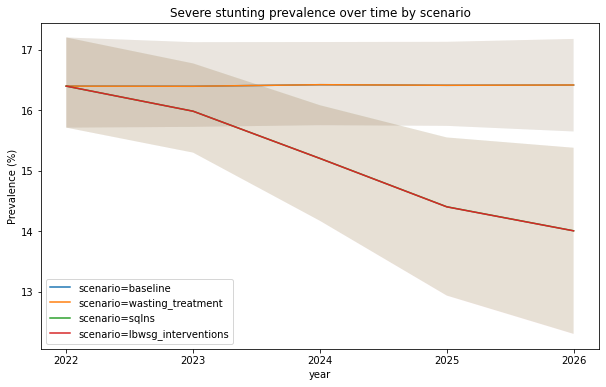

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    stunting_prevalence.query("stunting_state == 'cat1'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "Severe stunting prevalence over time by scenario"),
);
figs[title] = fig

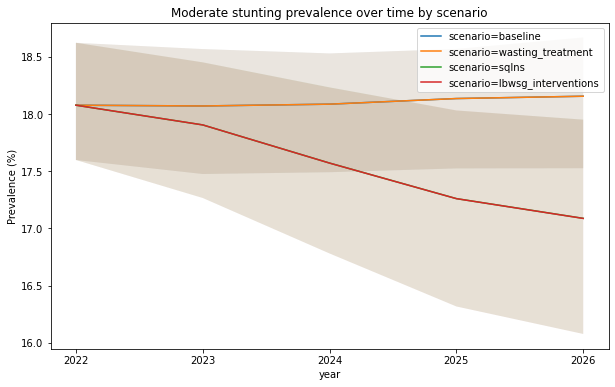

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    stunting_prevalence.query("stunting_state == 'cat2'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "Moderate stunting prevalence over time by scenario"),
);
figs[title] = fig

# Compute and plot prevalence of overall wasting and stunting

In [41]:
wasting_prevalence = vp.aggregate_categories(
    wasting_prevalence, 'wasting_state', csr.wasting_states_by_superstate, append=True)
wasting_prevalence

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,mild_child_wasting,20.639356,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,moderate_acute_malnutrition,7.477660,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,severe_acute_malnutrition,1.873702,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,susceptible_to_child_wasting,70.009281,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1436,2023,946,wasting_treatment,no_acute_malnutrition,91.091144,state_person_time,state_person_time,100,prevalence
1437,2024,946,wasting_treatment,no_acute_malnutrition,91.624449,state_person_time,state_person_time,100,prevalence
1438,2025,946,wasting_treatment,no_acute_malnutrition,92.074019,state_person_time,state_person_time,100,prevalence
1439,2026,946,wasting_treatment,no_acute_malnutrition,92.373875,state_person_time,state_person_time,100,prevalence


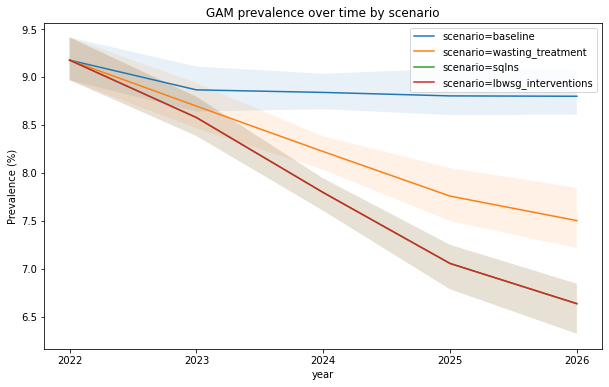

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    wasting_prevalence.query("wasting_state == 'global_acute_malnutrition'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "GAM prevalence over time by scenario"),
);
figs[title] = fig

In [42]:
stunting_prevalence = vp.aggregate_categories(
    stunting_prevalence, 'stunting_state', csr.stunting_states_by_superstate, append=True)
stunting_prevalence

,year,input_draw,scenario,stunting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,cat1,16.890041,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,cat2,17.604816,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,cat3,19.781513,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,cat4,45.723630,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1436,2023,946,wasting_treatment,stunted,34.663156,state_person_time,state_person_time,100,prevalence
1437,2024,946,wasting_treatment,stunted,34.778292,state_person_time,state_person_time,100,prevalence
1438,2025,946,wasting_treatment,stunted,34.743118,state_person_time,state_person_time,100,prevalence
1439,2026,946,wasting_treatment,stunted,34.829221,state_person_time,state_person_time,100,prevalence


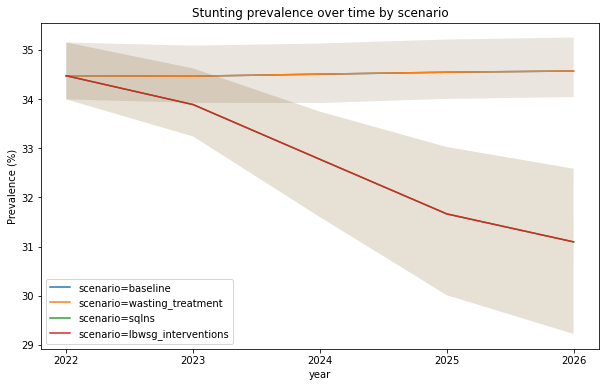

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    stunting_prevalence.query("stunting_state == 'stunted'"),
    colname='scenario',
    ylabel='Prevalence (%)',
    title=(title := "Stunting prevalence over time by scenario"),
);
figs[title] = fig

In [44]:
figs.keys()

dict_keys(['SAM prevalence over time by scenario', 'MAM prevalence over time by scenario', 'Severe stunting prevalence over time by scenario', 'Moderate stunting prevalence over time by scenario', 'GAM prevalence over time by scenario', 'Stunting prevalence over time by scenario'])

# Plot logarithms of prevalence

In [45]:
vp.value(wasting_prevalence)

value
denominator_measure input_draw measure    multiplier numerator_measure scenario          wasting_state                year           
state_person_time   29         prevalence 100        state_person_time baseline          mild_child_wasting           2022  20.639356
                                                                                         moderate_acute_malnutrition  2022   7.477660
                                                                                         severe_acute_malnutrition    2022   1.873702
                                                                                         susceptible_to_child_wasting 2022  70.009281
...                                                                                                                               ...
                    946        prevalence 100        state_person_time wasting_treatment no_acute_malnutrition        2023  91.091144
                                                                                                                      2024  91.624449
                                                                                                                      2025  92.074019
                                                                                                                      2026  92.373875

[1440 rows x 1 columns]

In [65]:
def apply_function(df, func):
    new_df = (
        df.pipe(vp.value)
        .pipe(func)
        .reset_index()
        .assign(measure=lambda df: df['measure'].map(lambda measure_string: f"{func.__name__}({measure_string})"))
    )
    return new_df

apply_function(wasting_prevalence, np.log)

,denominator_measure,input_draw,measure,multiplier,numerator_measure,scenario,wasting_state,year,value
0,state_person_time,29,log(prevalence),100,state_person_time,baseline,mild_child_wasting,2022,3.027200
1,state_person_time,29,log(prevalence),100,state_person_time,baseline,moderate_acute_malnutrition,2022,2.011920
2,state_person_time,29,log(prevalence),100,state_person_time,baseline,severe_acute_malnutrition,2022,0.627916
3,state_person_time,29,log(prevalence),100,state_person_time,baseline,susceptible_to_child_wasting,2022,4.248628
...,...,...,...,...,...,...,...,...,...
1436,state_person_time,946,log(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2023,4.511861
1437,state_person_time,946,log(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2024,4.517698
1438,state_person_time,946,log(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2025,4.522593
1439,state_person_time,946,log(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2026,4.525844


In [66]:
def reciprocal(x):
    return 1/x

apply_function(wasting_prevalence, reciprocal)

,denominator_measure,input_draw,measure,multiplier,numerator_measure,scenario,wasting_state,year,value
0,state_person_time,29,reciprocal(prevalence),100,state_person_time,baseline,mild_child_wasting,2022,0.048451
1,state_person_time,29,reciprocal(prevalence),100,state_person_time,baseline,moderate_acute_malnutrition,2022,0.133732
2,state_person_time,29,reciprocal(prevalence),100,state_person_time,baseline,severe_acute_malnutrition,2022,0.533703
3,state_person_time,29,reciprocal(prevalence),100,state_person_time,baseline,susceptible_to_child_wasting,2022,0.014284
...,...,...,...,...,...,...,...,...,...
1436,state_person_time,946,reciprocal(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2023,0.010978
1437,state_person_time,946,reciprocal(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2024,0.010914
1438,state_person_time,946,reciprocal(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2025,0.010861
1439,state_person_time,946,reciprocal(prevalence),100,state_person_time,wasting_treatment,no_acute_malnutrition,2026,0.010826


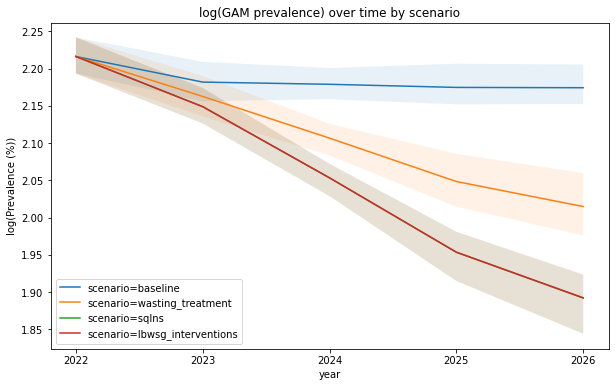

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    apply_function(wasting_prevalence.query("wasting_state == 'global_acute_malnutrition'"), np.log),
    colname='scenario',
    ylabel='log(Prevalence (%))',
    title=(title := "log(GAM prevalence) over time by scenario"),
);
figs[title] = fig

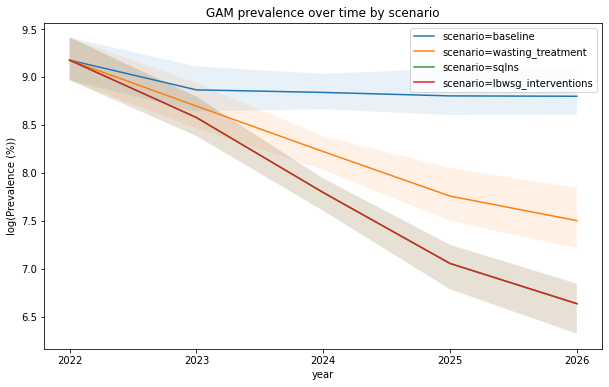

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    wasting_prevalence.query("wasting_state == 'global_acute_malnutrition'"),
    colname='scenario',
    ylabel='log(Prevalence (%))',
    title=(title := "GAM prevalence over time by scenario"),
);

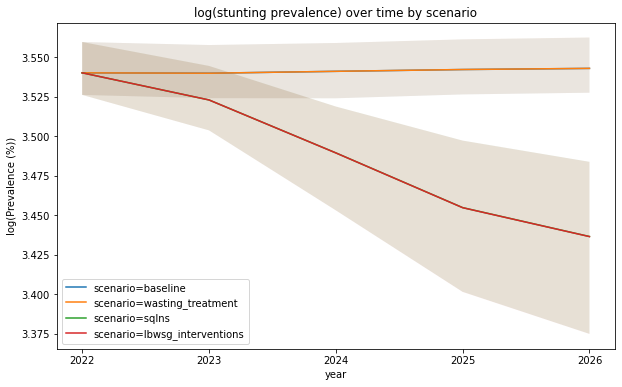

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
csp.plot_over_time_by_column(
    apply_function(stunting_prevalence.query("stunting_state == 'stunted'"), np.log),
    colname='scenario',
    ylabel='log(Prevalence (%))',
    title=(title := "log(stunting prevalence) over time by scenario"),
);
figs[title] = fig

In [63]:
reciprocal.__name__

'reciprocal'

In [64]:
np.log.__name__

'log'

In [73]:
figs.keys()

dict_keys(['SAM prevalence over time by scenario', 'MAM prevalence over time by scenario', 'Severe stunting prevalence over time by scenario', 'Moderate stunting prevalence over time by scenario', 'GAM prevalence over time by scenario', 'Stunting prevalence over time by scenario', 'log(GAM prevalence) over time by scenario', 'log(stunting prevalence) over time by scenario'])